## Callbacks in-the-middle

En este cuaderno se explica como lanzar una simulación desde PyHelios utilizando callbacks.

In [1]:
# Configurar entorno Jupyter
%config Completer.use_jedi = False

# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time
from datetime import datetime
from IPython.display import display, clear_output

# Importar pyhelios
PYHELIOS_LIB_PATH = '/home/uadmin/git/helios/cmake-build-release'
HELIOS_PATH = '/home/uadmin/git/helios'
sys.path.append(PYHELIOS_LIB_PATH)
sys.path.append(HELIOS_PATH)
if os.getcwd().endswith('pyhelios'):
    os.chdir(os.path.dirname(os.getcwd()))
import pyhelios

### Graficar una simulación conforme se va generando

Este ejemplo muestra como usar el sistema de callbacks para ir graficando la simulación conforme se va realizando.

In [2]:
# Cargar simulación ALS lineal
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/')
sim_builder = pyhelios.SimulationBuilder(
    os.path.join(root_dir, 'helios_basico/als_lineal/base/simulacion_als_lineal.xml'),
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Preparar gráfico para el callback
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Definir callback
cb_out = {  # Donde almacenar la salida del callback
    'T': None,
    'P': None
}
def my_callback(output):
    # El callback debe trabajar en un contexto con variable de condición
    with pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE:
        global cb_out  # Hacer accesible la lista global para la salida
        global fig, ax  # Hacer accesible el gráfico global
        if output is None:  # Ignorar salidas vacías
            pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE.notify()  # Notify antes de salir
            return
        P, T = pyhelios.outputToNumpy(output)  # Extraer puntos (P) y trayectoria (T)
        if T is not None and len(T) > 0:  # Almacenar la mitad de la trayectoria, si la hay
            if cb_out['T'] is None:
                cb_out['T'] = T[::2]
            else:
                cb_out['T'] = np.vstack([cb_out['T'], T[::2]])
        if P is not None and len(P) > 0:  # Almacenar 1/67 de los puntos, si los hay
            if cb_out['P'] is None:
                cb_out['P'] = P[::67]
            else:
                cb_out['P'] = np.vstack([cb_out['P'], P[::67]])
        # Actualizar gráfico
        ax.cla()
        ax.scatter(  # Puntos de la nube (coloreados por hitObjectId)
            cb_out['P'][:, 0], cb_out['P'][:, 1], cb_out['P'][:, 2], c=cb_out['P'][:, 14],
            s=4, label='Nubes'
        )
        ax.scatter(  #  Puntos de trayectoria en el gráfico
            cb_out['T'][:, 0], cb_out['T'][:, 1], cb_out['T'][:, 2], s=32, c=cb_out['T'][:, 3],
            cmap='jet', edgecolor='black', linewidths=0.1, label='Trayectoria', depthshade=False
        )
        ax.set_title('Graficación por callback', fontsize=20)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('$z$', fontsize=18)
        ax.set_xlim([-60, 100])
        ax.set_ylim([-80, 80])
        ax.set_zlim([-10, 110])
        ax.legend(loc='upper right', fontsize=18)
        fig.tight_layout()
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)
        pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE.notify()  # Notify antes de salir
sim_builder.setCallbackFrequency(50000)  # Llamar al callback cada x medidas
sim_builder.setCallback(my_callback)  # Asignar mi función de callback
    
# Construir la simulación
sim = sim_builder.build()

# Ejecutar la simulación
start = time.perf_counter()
sim.start()

# Esperar a que termine de ejecutarse la simulación
out = sim.join()  
end = time.perf_counter()

# Extraer información de interés
P, T = pyhelios.outputToNumpy(out)  # Nube y trayectoria como arrays de numpy
print(f'La simulación se ha ejecutado en {end-start:.3f} segundos.')
print(
    'La simulación ha generado un total de {m_nube} puntos.\n'
    'Se han registrado un total de {m_trayectoria} puntos de trayectoria.'
    .format(
        m_nube=P.shape[0],
        m_trayectoria=T.shape[0]
    )
)
print('Se han generado las siguientes nubes:')
for path in out.outpaths:
    print(f'\t{path}')

La simulación se ha ejecutado en 34.159 segundos.
La simulación ha generado un total de 2177467 puntos.
Se han registrado un total de 1002 puntos de trayectoria.
Se han generado las siguientes nubes:
	/home/uadmin/git/vlsdl_workshop2024/output/pyhelios//als_lineal/2024-09-23_13-04-11/leg000_points.laz
	/home/uadmin/git/vlsdl_workshop2024/output/pyhelios//als_lineal/2024-09-23_13-04-11/leg002_points.laz
	/home/uadmin/git/vlsdl_workshop2024/output/pyhelios//als_lineal/2024-09-23_13-04-11/leg004_points.laz


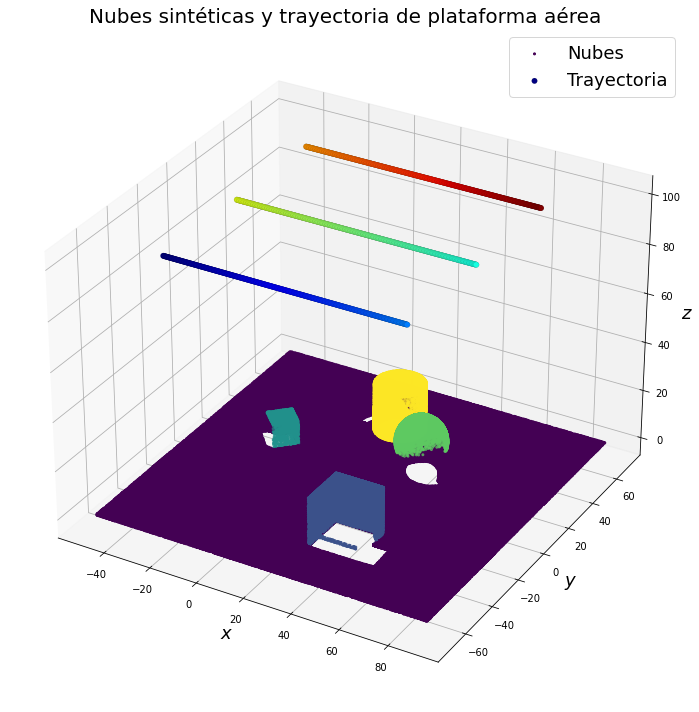

In [3]:
# Preparar contexto de graficación
fig = plt.figure(figsize=(16, 10))

# Graficar puntos de las nubes sintéticas
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(P[::3, 0], P[::3, 1], P[::3, 2], c=P[::3, 14], s=4, label='Nubes')

# Graficar la trayectoria de la plataforma aérea coloreada por tiempo
ax.scatter(
    T[:, 0], T[:, 1], T[:, 2],
    s=32, c=T[:, 3], cmap='jet', edgecolor='black', linewidths=0.1, label='Trayectoria', depthshade=False
)

# Configurar figura
ax.set_title('Nubes sintéticas y trayectoria de plataforma aérea', fontsize=20)
ax.legend(loc='best', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)
ax.set_zlabel('$z$', fontsize=18)
fig.tight_layout()

# Mostrar gráfico
plt.show()

### Ejercicio 1

Lanzar la simulación base de ALS lineal del bloque HELIOS básico con un callback para obtener los primeros $200,000$ puntos y graficarlos sin esperar a que termine la simulación.

In [4]:
# TODO : Codifíquese aquí la respuesta al Ejercicio 1

### Ejercicio 2

Lanzar la simulación base de ALS lineal del bloque HELIOS básico con un callback para añadir ruido normal a la componente $z$ de cada punto de suelo escaneado con media cero y desviación típica de $3\;\mathrm{cm}$. Generar una salida alternativa concatenando los distintos callbacks y compararla con la salida final sin alteraciones de dos maneras:

1) Calculando la media y la desviación típica de los puntos de suelo para cada caso. *Pista: Puede utilizarse el campo hitObjectId para identificar los puntos de suelo.*

2) Graficando el suelo de ambas nubes en 2D (e.g., z(x)).

In [5]:
# TODO : Codifíquese aquí la respuesta al Ejercicio 2

### Solución : Ejercicio 1

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/helios_basico/als_lineal/base/simulacion_als_lineal.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.01008849799836753 seconds


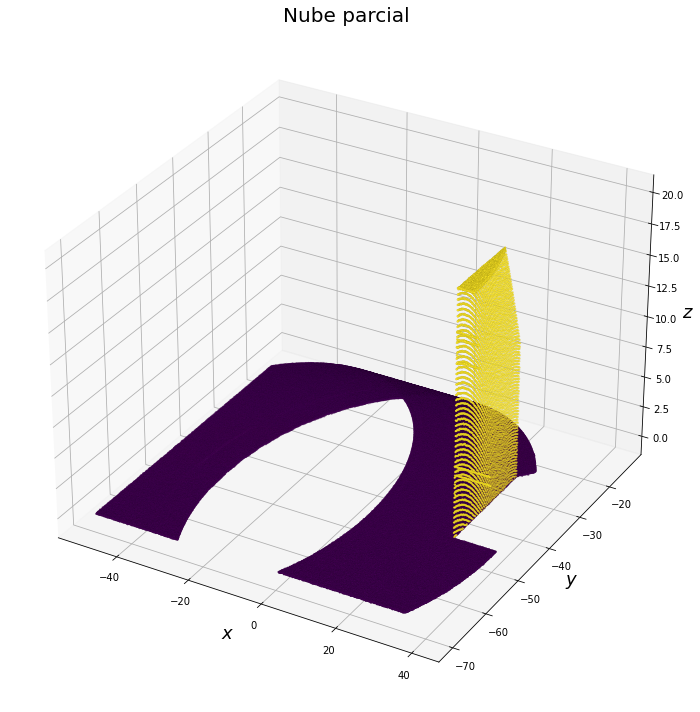

In [6]:
# Cargar simulación ALS lineal
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/')
sim_builder = pyhelios.SimulationBuilder(
    os.path.join(root_dir, 'helios_basico/als_lineal/base/simulacion_als_lineal.xml'),
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Definir callback
cb_out = []  # Donde almacenar la salida
cb_plot = False  # Flag para controlar si se ha generado el gráfico o no
MAX_POINTS = 200000  # Cuantos puntos se quieren capturar con el callback
def my_callback(output):
    # El callback debe trabajar en un contexto con variable de condición
    with pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE:
        global cb_out  # Hacer accesible la lista global para la salida
        global cb_plot  # Hacer accesible la flag para controlar el gráfico
        global MAX_POINTS  # Hacer accesible el gráfico global        
        if output is None:  # Ignorar salidas vacías
            pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE.notify()  # Notify antes de salir
            return
        # Extraer puntos y trayectoria
        P, T = pyhelios.outputToNumpy(output)
        # Capturar puntos hasta el máximo
        if P is not None and len(P) > 0 and len(cb_out) < MAX_POINTS:  # Almacenar puntos hasta el máximo
            if len(cb_out) == 0:
                cb_out = P[:MAX_POINTS]
            else:
                cb_out = np.vstack([cb_out, P[:MAX_POINTS-cb_out.shape[0]]])
        # Graficar (sólo una vez)
        if len(cb_out) == MAX_POINTS and not cb_plot:
            # Preparar contexto de graficación
            fig = plt.figure(figsize=(16, 10))
            # Graficar puntos de las nubes sintéticas
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            ax.scatter(
                cb_out[:, 0], cb_out[:, 1], cb_out[:, 2], c=cb_out[:, 14],
                s=4, edgecolor='black', linewidths=0.05
            )
            # Configurar figura
            ax.set_title('Nube parcial', fontsize=20)
            ax.set_xlabel('$x$', fontsize=18)
            ax.set_ylabel('$y$', fontsize=18)
            ax.set_zlabel('$z$', fontsize=18)
            fig.tight_layout()
            # Mostrar gráfico
            plt.show()
            cb_plot = True  # Marcar que el gráfico ya se ha hecho
        pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE.notify()  # Notify antes de salir
sim_builder.setCallbackFrequency(50000)  # Llamar al callback cada x medidas
sim_builder.setCallback(my_callback)  # Asignar mi función de callback
    
# Construir la simulación
sim = sim_builder.build()

# Ejecutar la simulación
start = time.perf_counter()
sim.start()

# Esperar a que termine de ejecutarse la simulación (el gráfico se habrá hecho antes)
out = sim.join()
end = time.perf_counter()

### Solución : Ejercicio 2

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/helios_basico/als_lineal/base/simulacion_als_lineal.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.009006525000586407 seconds


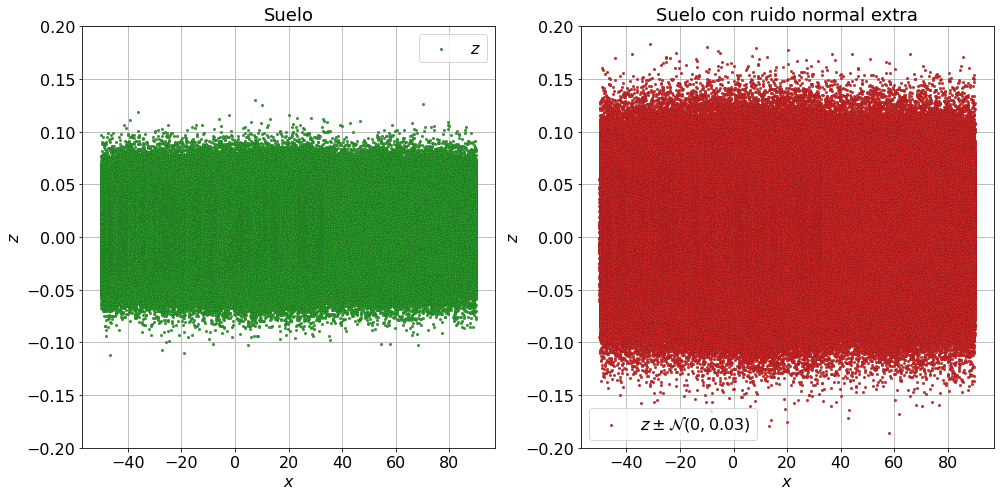

Nube (z): mu = 0.007, stdev = 0.023
Nube con ruido extra (z): mu = 0.007, stdev = 0.038


In [7]:
# Cargar simulación ALS lineal
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/')
sim_builder = pyhelios.SimulationBuilder(
    os.path.join(root_dir, 'helios_basico/als_lineal/base/simulacion_als_lineal.xml'),
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Definir callback
cb_out = []  # Donde almacenar la salida
def my_callback(output):
    # El callback debe trabajar en un contexto con variable de condición
    with pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE:
        global cb_out  # Hacer accesible la lista global para la salida
        if output is None:  # Ignorar salidas vacías
            pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE.notify()  # Notify antes de salir
            return
        # Extraer puntos y trayectoria
        P, T = pyhelios.outputToNumpy(output)
        # Capturar puntos con ruido
        if P is not None and len(P) > 0:  # Almacenar puntos hasta el máximo
            # Añadir ruido normal a la componente z de la nube
            P[:, 2] += np.random.normal(0, 0.03, P.shape[0])
            cb_out.append(P)            
        pyhelios.PYHELIOS_SIMULATION_BUILD_CONDITION_VARIABLE.notify()  # Notify antes de salir
sim_builder.setCallbackFrequency(50000)  # Llamar al callback cada x medidas
sim_builder.setCallback(my_callback)  # Asignar mi función de callback
    
# Construir la simulación
sim = sim_builder.build()

# Ejecutar la simulación
start = time.perf_counter()
sim.start()

# Esperar a que termine de ejecutarse la simulación
out = sim.join()
end = time.perf_counter()

# Extraer puntos y trayectoria finales
P, T = pyhelios.outputToNumpy(out)

# Extraer puntos de suelo en ambos casos
P = P[P[:, 14]==0]
cb_out = np.vstack(cb_out)  # Convertir lista a array
cb_out = cb_out[cb_out[:, 14]==0]

# Graficar : Figura
fig = plt.figure(figsize=(14, 7))
# Graficar : Nube sin ruido
ax = fig.add_subplot(1, 2, 1)
ax.scatter(
    P[:, 0], P[:, 2], s=8,
    color='tab:green', edgecolor='black', linewidths=0.1,
    label=r'$z$'
)
ax.set_title('Suelo', fontsize=18)
ax.set_ylim([-0.2, 0.2])
ax.grid('both')
ax.set_axisbelow(True)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$z$', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.legend(loc='best', fontsize=16)
# Graficar : Nube con ruido
ax = fig.add_subplot(1, 2, 2)
ax.scatter(
    cb_out[:, 0], cb_out[:, 2], s=8,
    color='tab:red', edgecolor='black', linewidths=0.1,
    label=r'$z \pm \mathcal{N}(0, 0.03)$'
)
ax.set_title('Suelo con ruido normal extra', fontsize=18)
ax.set_ylim([-0.2, 0.2])
ax.grid('both')
ax.set_axisbelow(True)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$z$', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.legend(loc='best', fontsize=16)
# Graficar: Mostrar figura
fig.tight_layout()
plt.show()

# Reportar media y desviación típica
Pz_mu, Pz_stdev = np.mean(P[:, 2]), np.std(P[:, 2])
cbz_mu, cbz_stdev = np.mean(cb_out[:, 2]), np.std(cb_out[:, 2])
print(
    f'Nube (z): mu = {Pz_mu:.3f}, stdev = {Pz_stdev:.3f}\n'
    f'Nube con ruido extra (z): mu = {cbz_mu:.3f}, stdev = {cbz_stdev:.3f}'
)